In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

import missingno as msno

import statsmodels.formula.api as smf
import statsmodels.api as sm

from scipy.cluster.hierarchy import dendrogram
import plotly.graph_objects as go

from sklearn.decomposition import PCA, SparsePCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
#from sklearn.experimental import enable_iterative_imputer
#from sklearn.impute import SimpleImputer, IterativeImputer

import random

from unidecode import unidecode

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [2]:
data = pd.read_csv('./data/2016_Building_Energy_Benchmarking.csv')

In [3]:
print("Fichier de dimension " + str(data.shape) + " :\n")

print("\n\nType des colonnes :")
print(data.dtypes.to_markdown())

print("\n\nTaux de remplissage (%) :")
print(((1- data.isna().mean())*100).to_markdown())

print("\n\nNombre de valeurs uniques par colones :")
print(data.nunique().to_markdown())

Fichier de dimension (3376, 46) :



Type des colonnes :
|                                 | 0       |
|:--------------------------------|:--------|
| OSEBuildingID                   | int64   |
| DataYear                        | int64   |
| BuildingType                    | object  |
| PrimaryPropertyType             | object  |
| PropertyName                    | object  |
| Address                         | object  |
| City                            | object  |
| State                           | object  |
| ZipCode                         | float64 |
| TaxParcelIdentificationNumber   | object  |
| CouncilDistrictCode             | int64   |
| Neighborhood                    | object  |
| Latitude                        | float64 |
| Longitude                       | float64 |
| YearBuilt                       | int64   |
| NumberofBuildings               | float64 |
| NumberofFloors                  | int64   |
| PropertyGFATotal                | int64   |
| PropertyGFAParking   

<AxesSubplot: >

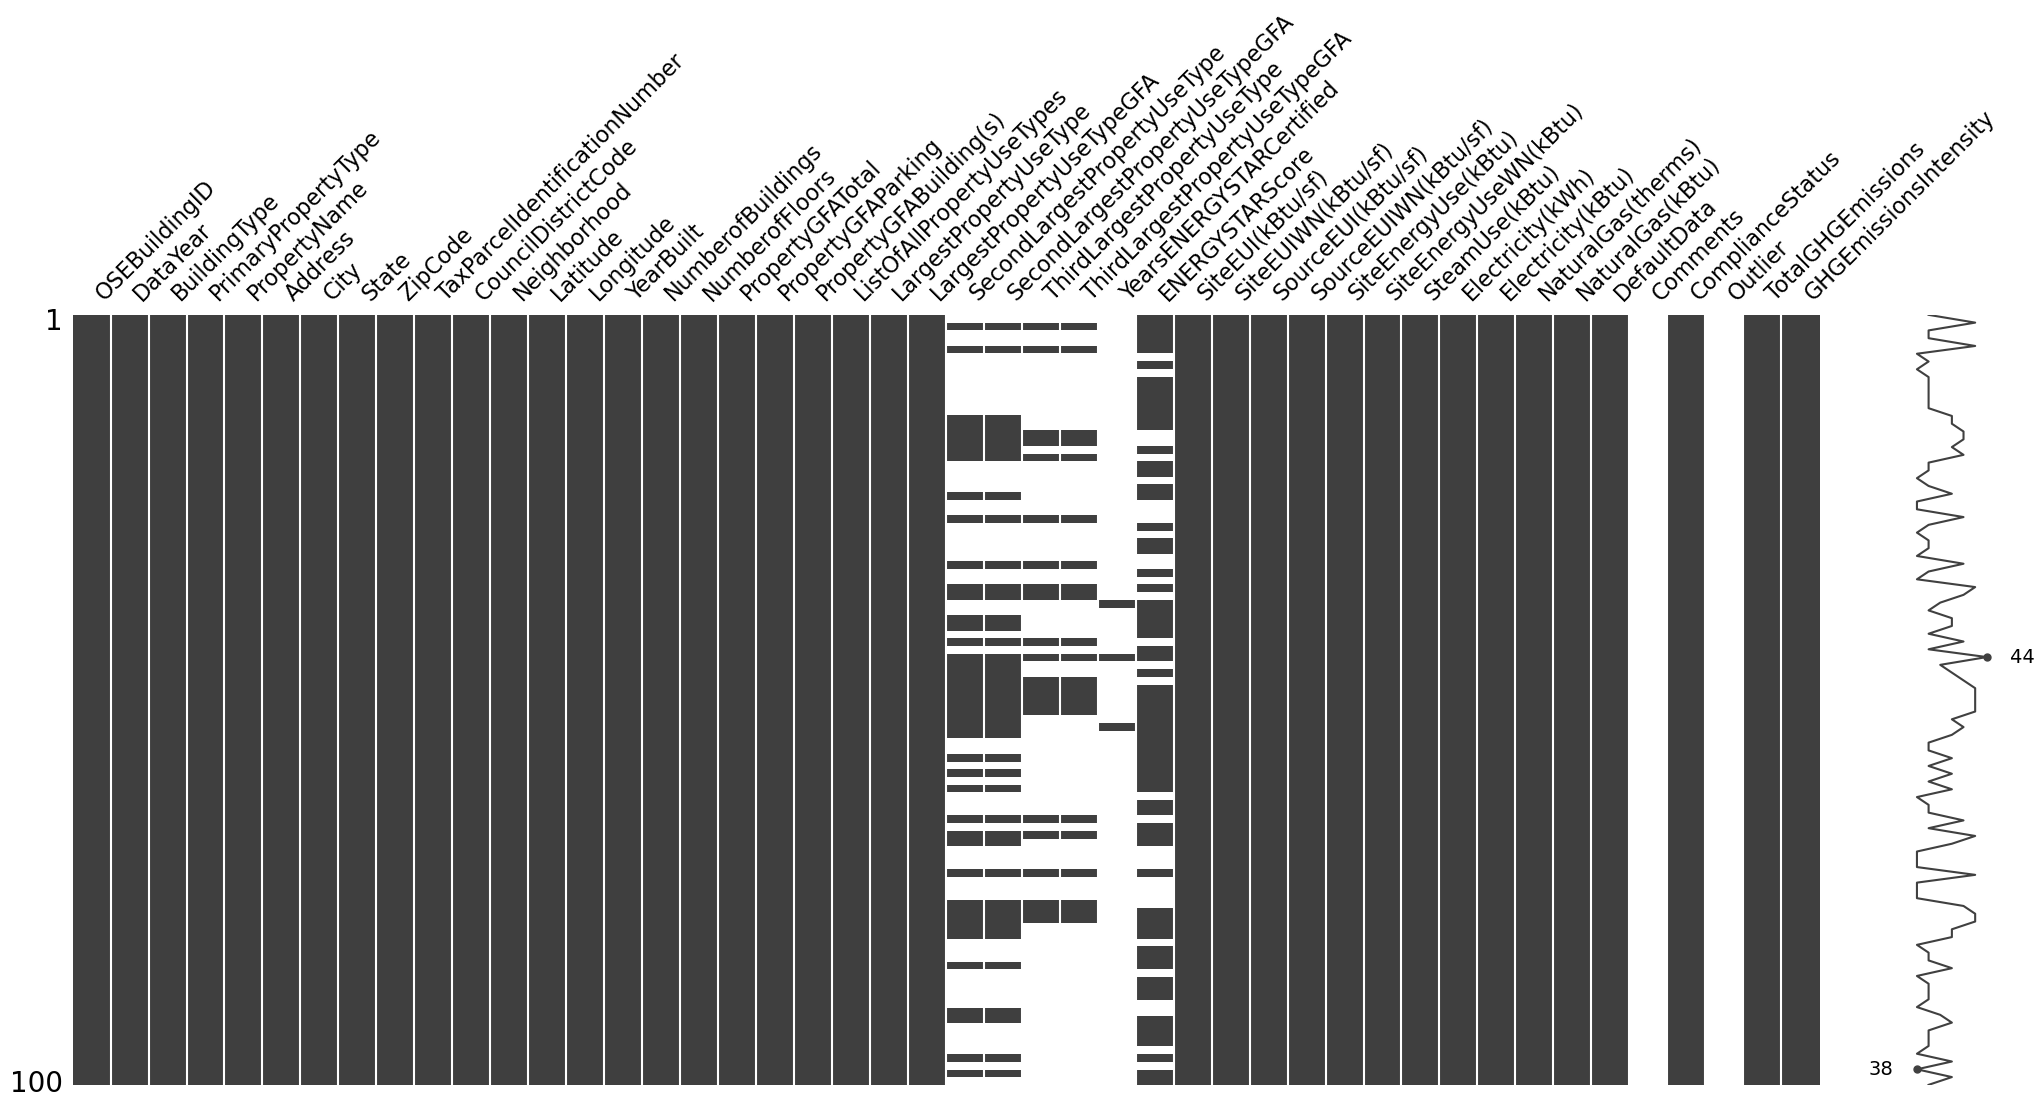

In [4]:
msno.matrix(data[:100])

<AxesSubplot: >

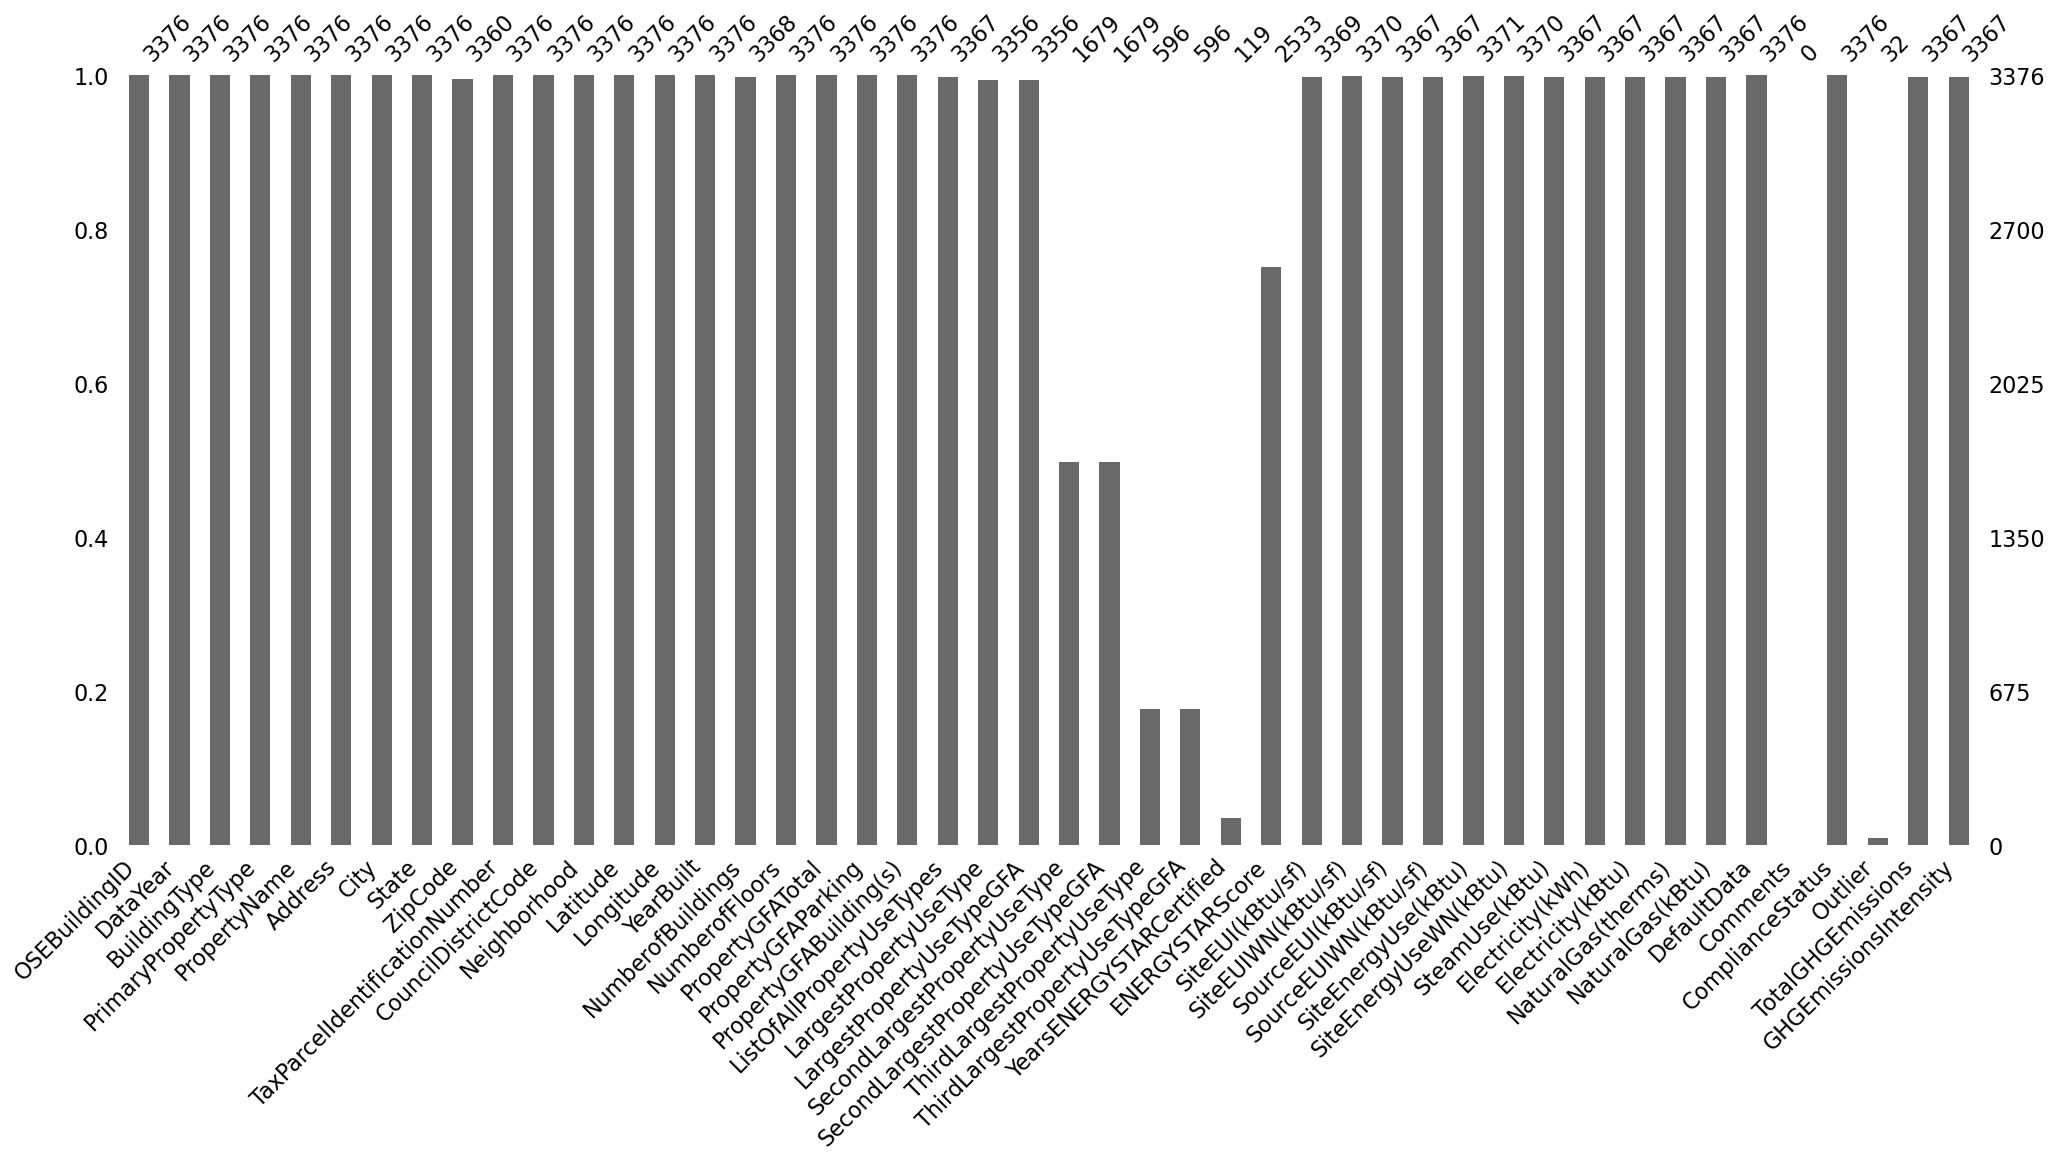

In [5]:
msno.bar(data)

In [6]:
data.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,...,8.115253e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,...,1.573449e+06,5368607.0,88039.98438,8803998.0,False,NaN,Compliant,NaN,505.01,2.88


In [7]:
@interact
def show_describe(column=list(data.columns)):
    return data[column].describe().T

interactive(children=(Dropdown(description='column', options=('OSEBuildingID', 'DataYear', 'BuildingType', 'Pr…

In [8]:
@interact
def show_extract(column=list(data.columns), x=(0, 300, 1)):
    tmp = data.loc[~data[column].isna(), column]
    return tmp.iloc[x:x+10]

interactive(children=(Dropdown(description='column', options=('OSEBuildingID', 'DataYear', 'BuildingType', 'Pr…

In [9]:
@interact
def show_extract(column=list(data.columns)):
    tmp = data[column].value_counts()
    print(len(tmp))
    return data[column].value_counts().iloc[:20]

interactive(children=(Dropdown(description='column', options=('OSEBuildingID', 'DataYear', 'BuildingType', 'Pr…

In [10]:
t = (int, 'discrete', 'continue', 'nominal', 'ordinal')

In [11]:
for c in ['ZipCode', 'NumberofBuildings', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA']:
    data[c] = data[c].astype('int64', errors='ignore')

In [12]:
COL = {'OSEBuildingID': ('string', 'nominal'),
       'DataYear':('int64', 'discrete'),
       'BuildingType':('category', ('string', 'nominal')),
       'PrimaryPropertyType':('category', ('string', 'nominal')),
       'PropertyName':('string', 'nominal'),
       'Address':('string', 'nominal'),
       'City':('category', ('string', 'nominal')),
       'State':('category', ('string', 'nominal')),
       'ZipCode':('category', ('string', 'nominal')),
       'TaxParcelIdentificationNumber':('string', 'nominal'),
       'CouncilDistrictCode':('category', ('string', 'nominal')),
       'Neighborhood':('category', ('string', 'nominal')),
       'Latitude':('float32', 'continue'),
       'Longitude':('float32', 'continue'),
       'YearBuilt':('int64', 'discrete'),
       'NumberofBuildings':('int64', 'discrete'),
       'NumberofFloors':('int64', 'discrete'),
       'PropertyGFATotal':('int64', 'discrete'),
       'PropertyGFAParking':('int64', 'discrete'),
       'PropertyGFABuilding(s)':('int64', 'discrete'),
       'ListOfAllPropertyUseTypes':('category', ('string', 'nominal')),
       'LargestPropertyUseType':('category', ('string', 'nominal')),
       'LargestPropertyUseTypeGFA':('int64', 'discrete'),
       'SecondLargestPropertyUseType':('category', ('string', 'nominal')),
       'SecondLargestPropertyUseTypeGFA':('int64', 'discrete'),
       'ThirdLargestPropertyUseType':('category', ('string', 'nominal')),
       'ThirdLargestPropertyUseTypeGFA':('int64', 'discrete'),
       'YearsENERGYSTARCertified':('string', 'nominal'),
       'ENERGYSTARScore':('float32', 'continue'),
       'SiteEUI(kBtu/sf)':('float32', 'continue'),
       'SiteEUIWN(kBtu/sf)':('float32', 'continue'),
       'SourceEUI(kBtu/sf)':('float32', 'continue'),
       'SourceEUIWN(kBtu/sf)':('float32', 'continue'),
       'SiteEnergyUse(kBtu)':('float32', 'continue'),
       'SiteEnergyUseWN(kBtu)':('float32', 'continue'),
       'SteamUse(kBtu)':('float32', 'continue'),
       'Electricity(kWh)':('float32', 'continue'),
       'Electricity(kBtu)':('float32', 'continue'),
       'NaturalGas(therms)':('float32', 'continue'),
       'NaturalGas(kBtu)':('float32', 'continue'),
       'DefaultData':('boolean', 'nominal'),
       'Comments':('string', 'nominal'),
       'ComplianceStatus':('category', ('string', 'nominal')),
       'Outlier':('category', ('string', 'nominal')),
       'TotalGHGEmissions':('float32', 'continue'),
       'GHGEmissionsIntensity':('float32', 'continue')}

In [13]:
for c, e in COL.items():
    t, o = e
    if t == 'category':
        t, o = o
        data[c] = data[c].astype(t, errors='ignore').astype('category', errors='ignore')
    else:
        data[c] = data[c].astype(t, errors='ignore')

In [14]:
col_nan = set(['Comments', 'Outlier', 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
              'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA', 'YearsENERGYSTARCertified'])
col_Y =  ['SiteEnergyUse(kBtu)', 'TotalGHGEmissions']
col_Y_rename = ['Energy', 'CO2']

In [15]:
data = data.sample(frac=1)

In [16]:
data_X_star = data[[e for e in data.columns if e not in col_nan]].copy().dropna()
data_X = data[[e for e in data.columns if e not in col_nan and e != 'ENERGYSTARScore']].copy().dropna()

data_Y_star = pd.DataFrame()
data_Y = pd.DataFrame()

data_Y_star[col_Y_rename] = data_X_star[col_Y].copy()
data_Y[col_Y_rename] = data_X[col_Y].copy()

data_X_star = data_X_star.drop(col_Y, axis=1)
data_X = data_X.drop(col_Y, axis=1)

In [17]:
import pickle

with open("./data/pickle", 'wb') as f:
    pickle.dump(([data_X, data_X_star], [data_Y, data_Y_star]), f)

In [14]:
data['City']

0       Seattle
1       Seattle
2       Seattle
3       Seattle
4       Seattle
         ...   
3371    Seattle
3372    Seattle
3373    Seattle
3374    Seattle
3375    Seattle
Name: City, Length: 3376, dtype: category
Categories (1, string): [Seattle]

In [15]:
@interact
def show_extract(column=list(data.select_dtypes(include=['category', 'int']).columns)):
    tmp = data[column].value_counts().iloc[:30]

    plt.barh(list(tmp.index), tmp.values)

    plt.title("Nombre d'occurences pour {}".format(column))
    plt.ylabel("Nombre d'occurences")

    plt.show()

interactive(children=(Dropdown(description='column', options=('DataYear', 'BuildingType', 'PrimaryPropertyType…

In [16]:
data.select_dtypes(include=['float', 'int'])

,DataYear,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,...,SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
0,2016,47.612202,-122.337990,1927,1.0,12,88434,0,88434,88434.0,...,189.000000,7.226362e+06,7.456910e+06,2003882.00,1.156514e+06,3.946027e+06,12764.529297,1.276453e+06,249.979996,2.83
1,2016,47.613171,-122.333931,1996,1.0,11,103566,15064,88502,83880.0,...,179.399994,8.387933e+06,8.664479e+06,0.00,9.504252e+05,3.242851e+06,51450.816406,5.145082e+06,295.859985,2.86
2,2016,47.613930,-122.338097,1969,1.0,41,956110,196718,759392,756493.0,...,244.100006,7.258702e+07,7.393711e+07,21566554.00,1.451544e+07,4.952666e+07,14938.000000,1.493800e+06,2089.280029,2.19
3,2016,47.614120,-122.336639,1926,1.0,10,61320,0,61320,61320.0,...,224.000000,6.794584e+06,6.946800e+06,2214446.25,8.115253e+05,2.768924e+06,18112.130859,1.811213e+06,286.429993,4.67
4,2016,47.613750,-122.340469,1980,1.0,18,175580,62000,113580,123445.0,...,215.600006,1.417261e+07,1.465650e+07,0.00,1.573449e+06,5.368607e+06,88039.984375,8.803998e+06,505.010010,2.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,2016,47.567219,-122.311539,1990,1.0,1,12294,0,12294,12294.0,...,176.100006,8.497457e+05,9.430032e+05,0.00,1.536550e+05,5.242709e+05,3254.750244,3.254750e+05,20.940001,1.70
3372,2016,47.596249,-122.322830,2004,1.0,1,16000,0,16000,16000.0,...,118.900002,9.502762e+05,1.053706e+06,0.00,1.162210e+05,3.965461e+05,5537.299805,5.537300e+05,32.169998,2.01
3373,2016,47.636440,-122.357841,1974,1.0,1,13157,0,13157,7583.0,...,767.799988,5.765898e+06,6.053764e+06,0.00,5.252517e+05,1.792159e+06,39737.390625,3.973739e+06,223.539993,16.99
3374,2016,47.528320,-122.324310,1989,1.0,1,14101,0,14101,6601.0,...,110.800003,7.194712e+05,7.828413e+05,0.00,1.022480e+05,3.488702e+05,3706.010010,3.706010e+05,22.110001,1.57


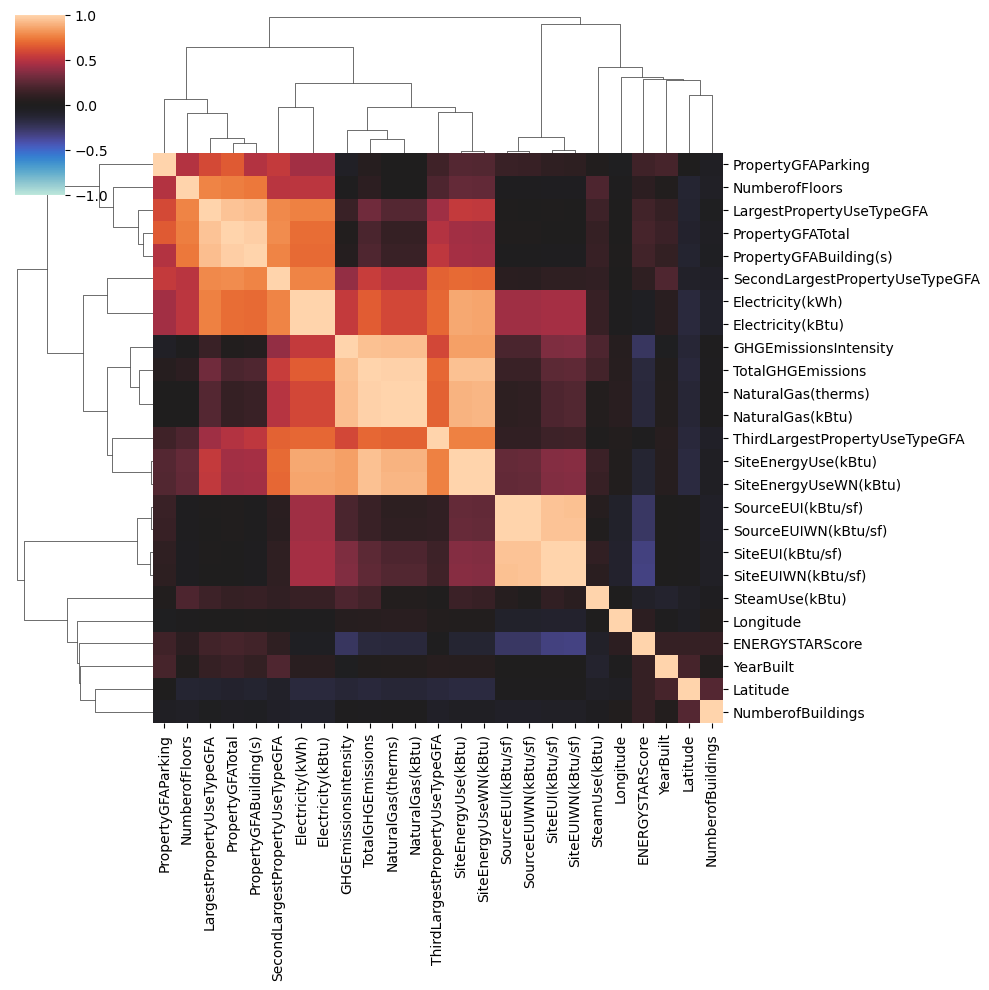

In [17]:
dataTmp = data.loc[:, 'Latitude':].select_dtypes(include=['float', 'int']).dropna().corr()
h = sns.clustermap(dataTmp, vmin=-1, vmax=1, center=0)

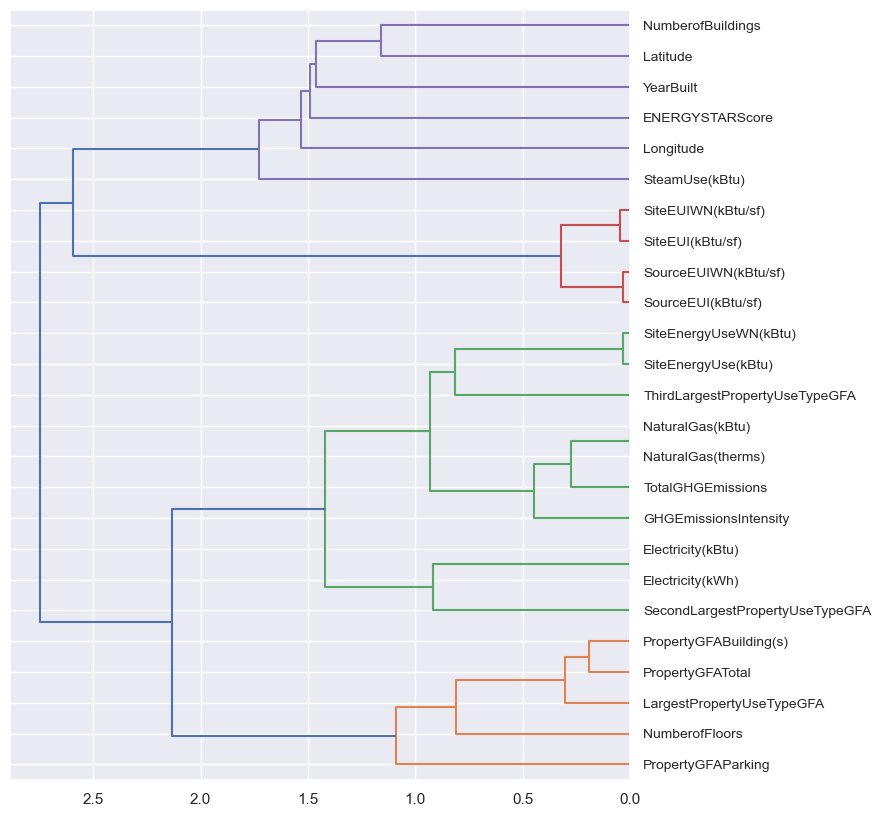

In [18]:
sns.set(rc={"figure.figsize":(8, 10)})
dendrogram(h.dendrogram_col.linkage, labels=dataTmp.columns, orientation='left');

In [171]:
from sklearn import preprocessing


lTmp = list(data.select_dtypes(include=['int', 'float']).columns)

std_scale = preprocessing.StandardScaler().fit(data[lTmp])
dataTmp = data.copy()
dataTmp[lTmp] = std_scale.transform(dataTmp[lTmp])

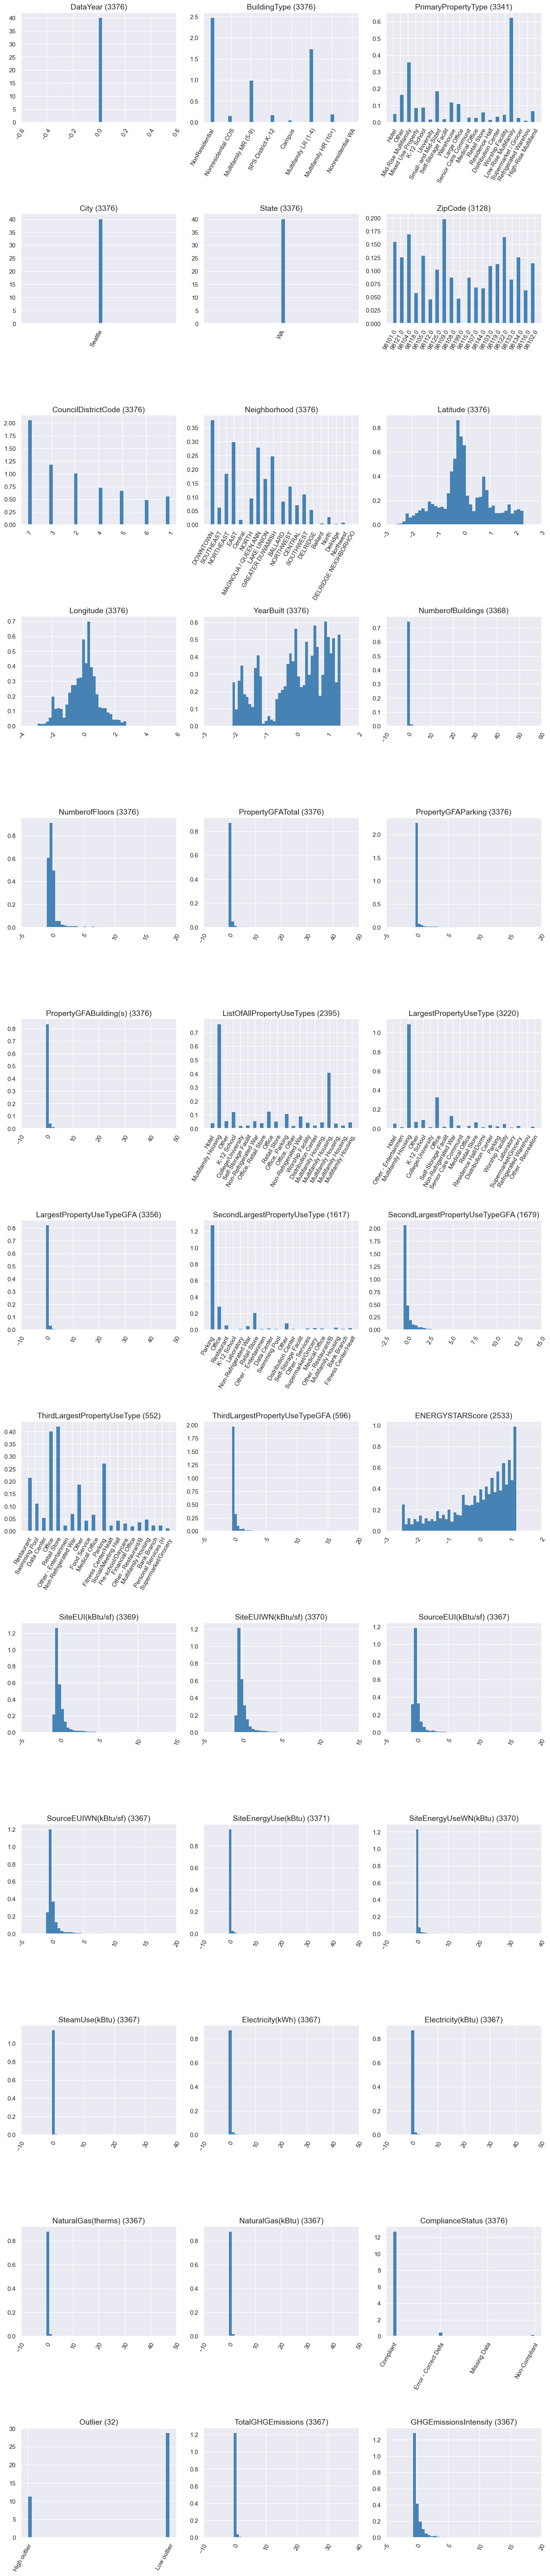

In [172]:
lTmp = list(data.select_dtypes(include=['category', 'int', 'float']).columns)
tTmp = len(lTmp)

fig = plt.figure(figsize=(14,  5 * tTmp/3))

for feat_idx in range(tTmp):
    ax = fig.add_subplot((2+tTmp)//3, 3, (feat_idx+1))
    
    tmp = data[lTmp[feat_idx]].dropna().copy()
    if tmp.dtype == 'category':
        tmp = tmp.loc[tmp.isin(tmp.value_counts()[:20].index)]
    
    h = ax.hist(tmp, bins=40, color='steelblue', density=True, edgecolor='none')
    ax.set_title("{} ({})".format(lTmp[feat_idx], len(tmp)), fontsize=14)
    ax.set_xticks(ax.get_xticks(), [x.get_text()[:20] for x in ax.get_xticklabels()], rotation=60, ha='right', rotation_mode='anchor')

fig.tight_layout(pad=1)
plt.show()

In [161]:
from math import *
from matplotlib.colors import LogNorm

In [165]:
sns.set(rc={"figure.figsize":(8, 6)})

@interact
def show_articles_more_than(couleur=data.select_dtypes(include=['int', 'float']).columns):
    x = data["Longitude"]
    y = data["Latitude"]

    c = data[couleur]

    fig = plt.figure()
    ax = plt.axes()
    
    if couleur in ['NumberofFloors', 'NumberofBuildings'] or '(' in couleur:
        sc = ax.scatter(x, y, c=c, s=0, alpha=1, norm=LogNorm())
        ax.scatter(x, y, c=c, s=50, alpha=0.2, norm=LogNorm())
    else:
        sc = ax.scatter(x, y, c=c, s=0, alpha=1)
        ax.scatter(x, y, c=c, s=50, alpha=0.2)
        


    cb = fig.colorbar(sc, ax=ax)
    
    plt.show()

interactive(children=(Dropdown(description='couleur', options=('DataYear', 'Latitude', 'Longitude', 'YearBuilt…